# Exploring OLS models before pipelining

 Wrap preprocessing + estimator in an sklearn Pipeline and dump with joblib.

 Store model files under models/ but track them with DVC or MLflow.

 Use Papermill or nbconvert to transform exploratory notebooks into parameterised, non-interactive steps.

 Orchestrate regular re-training with Prefect or similar.

 Preserve Python environment specs next to the artefact.

**TODO**: Maybe docker implementation for automated workflow

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from pathlib import Path     
import models 
import mlflow
import os
import subprocess
import time


In [2]:
def kill_process_on_port(port):
    try:
        result = subprocess.check_output(f"lsof -ti tcp:{port}", shell=True, text=True)
        pids = result.strip().split('\n')
        for pid in pids:
            if pid:
                print(f"Killing process {pid} on port {port}")
                os.system(f"kill -9 {pid}")
    except subprocess.CalledProcessError:
        print(f"No process found on port {port}")

def start_mlflow_ui(port=5000):
    kill_process_on_port(port)
    print(f"Starting MLflow UI on port {port} ...")
    subprocess.Popen(
        ["mlflow", "ui", "--host", "127.0.0.1", "--port", str(port)],
        stdout=subprocess.DEVNULL,
        stderr=subprocess.DEVNULL
    )
    time.sleep(3)
    print(f"MLflow UI running at http://127.0.0.1:{port}")

start_mlflow_ui()

Killing process 3991 on port 5000
Starting MLflow UI on port 5000 ...
MLflow UI running at http://127.0.0.1:5000


In [3]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000/")


file_path = Path("/home/user/data/sector_10.parquet")

file_path.name  # → "sector_10.parquet"

file_path.stem  # → "sector_10"

.glob: indicates patterns to be found within the dir

In [4]:
data_dir = Path.cwd().parent/'data'

df_dict = {
    file.stem.replace("sector_","") : pd.read_parquet(file)
    for file in data_dir.glob("sector_*.parquet")
}

/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/pandas/core/frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(
/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/pandas/co

In [5]:
features_c4f = ['excess_mkt_ret','smb', 'hml','umd']

In [6]:
features_ff5 = ['excess_mkt_ret','smb', 'hml','umd','cma']

In [7]:
features_c4f_enhanced = ['excess_mkt_ret','smb', 'hml','umd','turn','turn_sd','mvel1','dolvol','daily_illq','zero_trade_ratio','baspread','enhanced_baker','vix_close','put_call_ratio','news_sent']

In [ ]:
features_ff5_enhanced = ['excess_mkt_ret','smb', 'hml','umd','cma','turn','turn_sd','mvel1','dolvol','daily_illq','zero_trade_ratio','baspread','enhanced_baker','vix_close','put_call_ratio','news_sent']

# OLS baseline: c4f+ff5

In [ ]:
df_dict['10'].columns

3FF

Testing the number of lags chosen

In [ ]:
# import statsmodels.api as sm
# from statsmodels.tsa.stattools import acf
# olstest_x = df_dict['10'][features_ff5_enhanced]
# olstest_y= df_dict['10']['excess_ret']
# olstest_model = sm.OLS(olstest_y,olstest_x).fit()

# rho, confint = acf(olstest_model.resid, nlags=50, alpha=0.05)

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(confint[:,0], label='lower confint')
# plt.plot(confint[:,1], '--', label='upper confint')

3 should be good number of lags

Testing for r2 neg

In [ ]:
model = models.olsmodel(
        y='excess_ret',
        features=features_c4f,
        lags=3,
        run_name=f'r2negtest',
        fama_french_ver='c4f',
        experiment_name='r2negtest'
    )
model.fit(df_dict['10'])


OFFICAL RUN

In [ ]:
for sector, df in df_dict.items():
    model = models.olsmodel(
        y='excess_ret',
        features=features_c4f,
        lags=3,
        run_name=f'{sector}_baseline',
        fama_french_ver='c4f',
        experiment_name='baseline_ols'
    )
    model.fit(df)


Creating runs in the same experiment with famafrench 5

In [ ]:
for sector, df in df_dict.items():
    model = models.olsmodel(
        y='excess_ret',
        features=features_ff5,
        lags=3,
        run_name=f'{sector}_baseline',
        fama_french_ver='ff5',
        experiment_name='baseline_ols'
    )
    model.fit(df)
  


## OLS Enhanced c4f+ff5

In [ ]:
df_dict['10'].columns

In [ ]:
for sector, df in df_dict.items():
    model = models.olsmodel(
        y='excess_ret',
        features=features_c4f_enhanced,
        lags=3,
        run_name=f'{sector}_enhanced',
        fama_french_ver='c4f_enhanced',
        experiment_name='enhanced_ols'
    )
    model.fit(df)
  


In [ ]:
for sect, df in df_dict.items():
    corr = df[features_c4f_enhanced].corr()

In [ ]:
df_dict['10'].corr()

Zero_trade_ratio is almost all zeroes, making its VIF NaN. Turn_sd is dervied from turn, making it perfcet multicollin

In [ ]:
df_dict['10']['zero_trade_ratio'].nunique()
df_dict['10']['zero_trade_ratio'].describe()

FF5 enhanced


In [ ]:
for sector, df in df_dict.items():
    model = models.olsmodel(
        y='excess_ret',
        features=features_ff5_enhanced,
        lags=3, 
        run_name=f'{sector}_enhanced',
        fama_french_ver='ff5_enhanced',
        experiment_name='enhanced_ols'
    )
    model.fit(df)
  


# Random Forest playground

Test r2 neg

/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/IPython/extensions/deduperreload/deduperreload.py:290: DeprecationWarning: ast.Ellipsis is deprecated and will be removed in Python 3.14; use ast.Constant instead
  elif not isinstance(ast_elt, (ast.Ellipsis, ast.Pass)):
/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/IPython/extensions/deduperreload/deduperreload.py:290: DeprecationWarning: ast.Ellipsis is deprecated and will be removed in Python 3.14; use ast.Constant instead
  elif not isinstance(ast_elt, (ast.Ellipsis, ast.Pass)):
/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/IPython/extensions/deduperreload/deduperreload.py:290: DeprecationWarning: ast.Ellipsis is deprecated and will be removed in Python 3.14; use ast.Constant instead
  elif not isinstance(ast_elt, (ast.Ellipsis, ast.Pass)):
/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/IPython/extensions/deduperreload/deduperreload.py:290: DeprecationWarning: ast.Ellipsis is deprecated

Experiment already exists with ID: 580106255596875282


/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/mlflow/models/model.py:365: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_time_created = str(utc_time_created or datetime.utcnow())
Registered model 'rf_c4f_testrf1_r2negtest' already exists. Creating a new version of this model...
2025/05/30 09:58:36 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: rf_c4f_testrf1_r2negtest, version 2
Created version '2' of model 'rf_c4f_testrf1_r2negtest'.
/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/mlflow/models/model.py:365: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  self.utc_ti

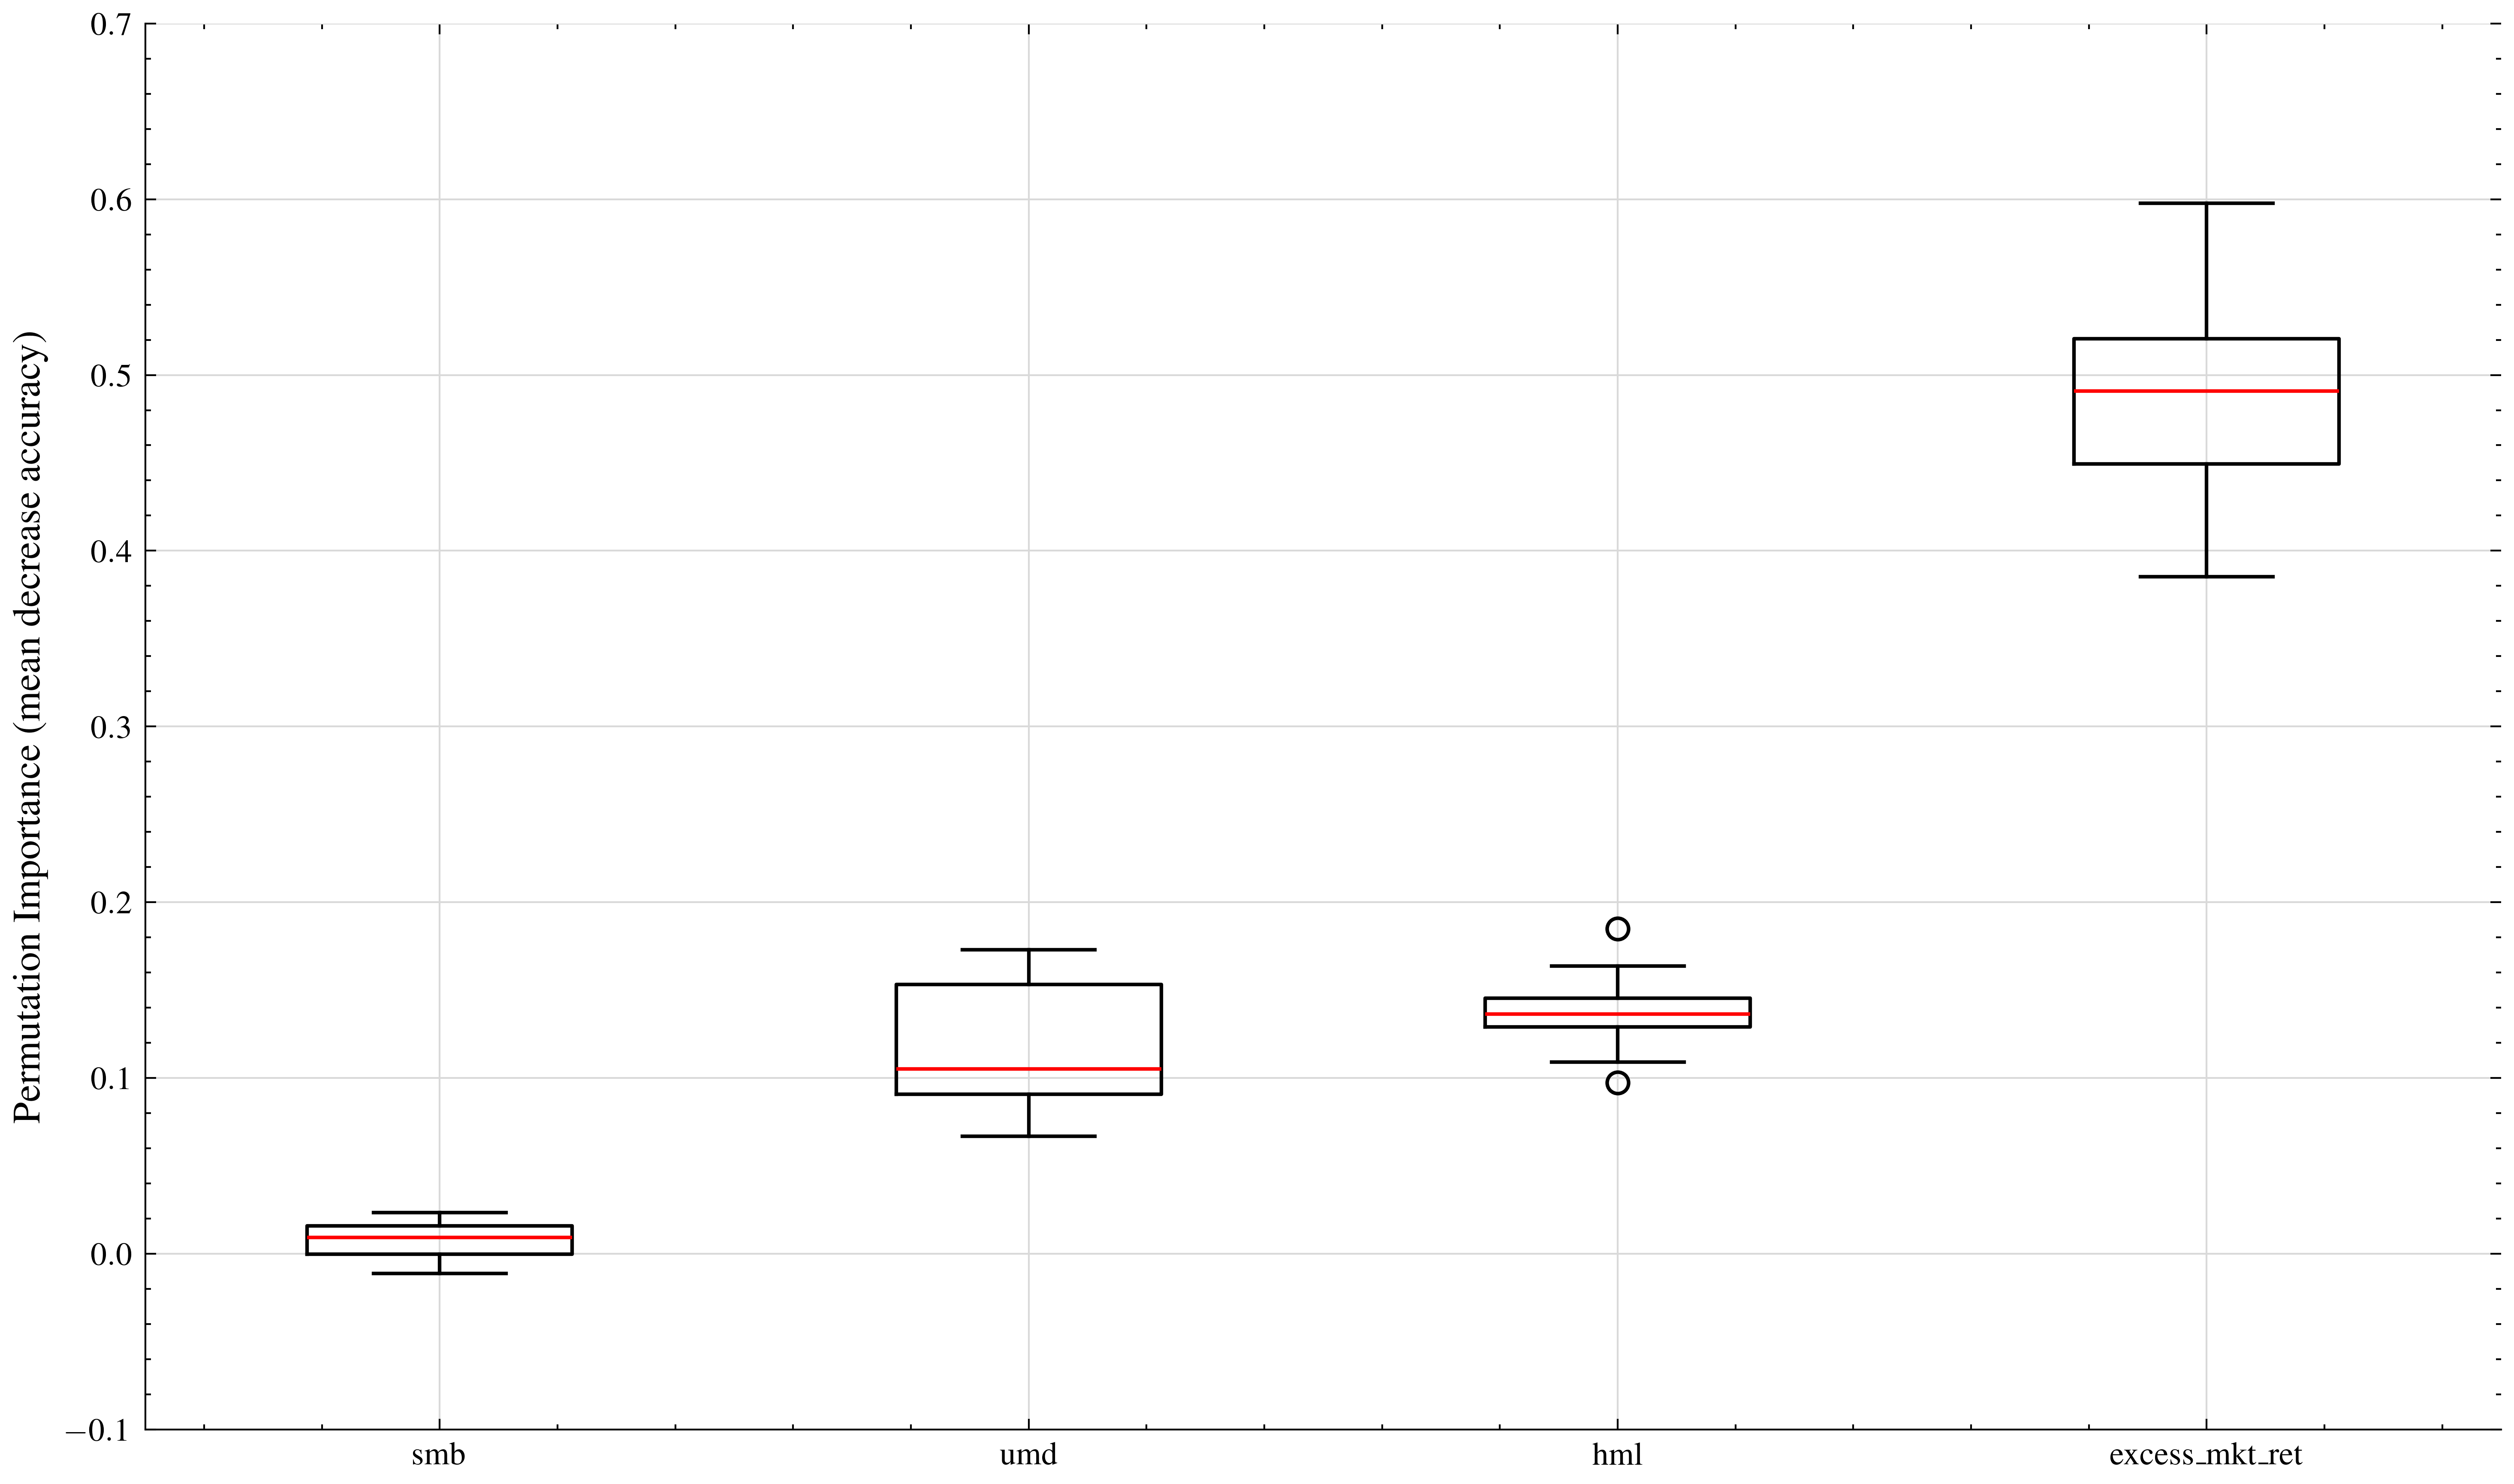

Displayed: Permutation Importance plot for rf - testrf1


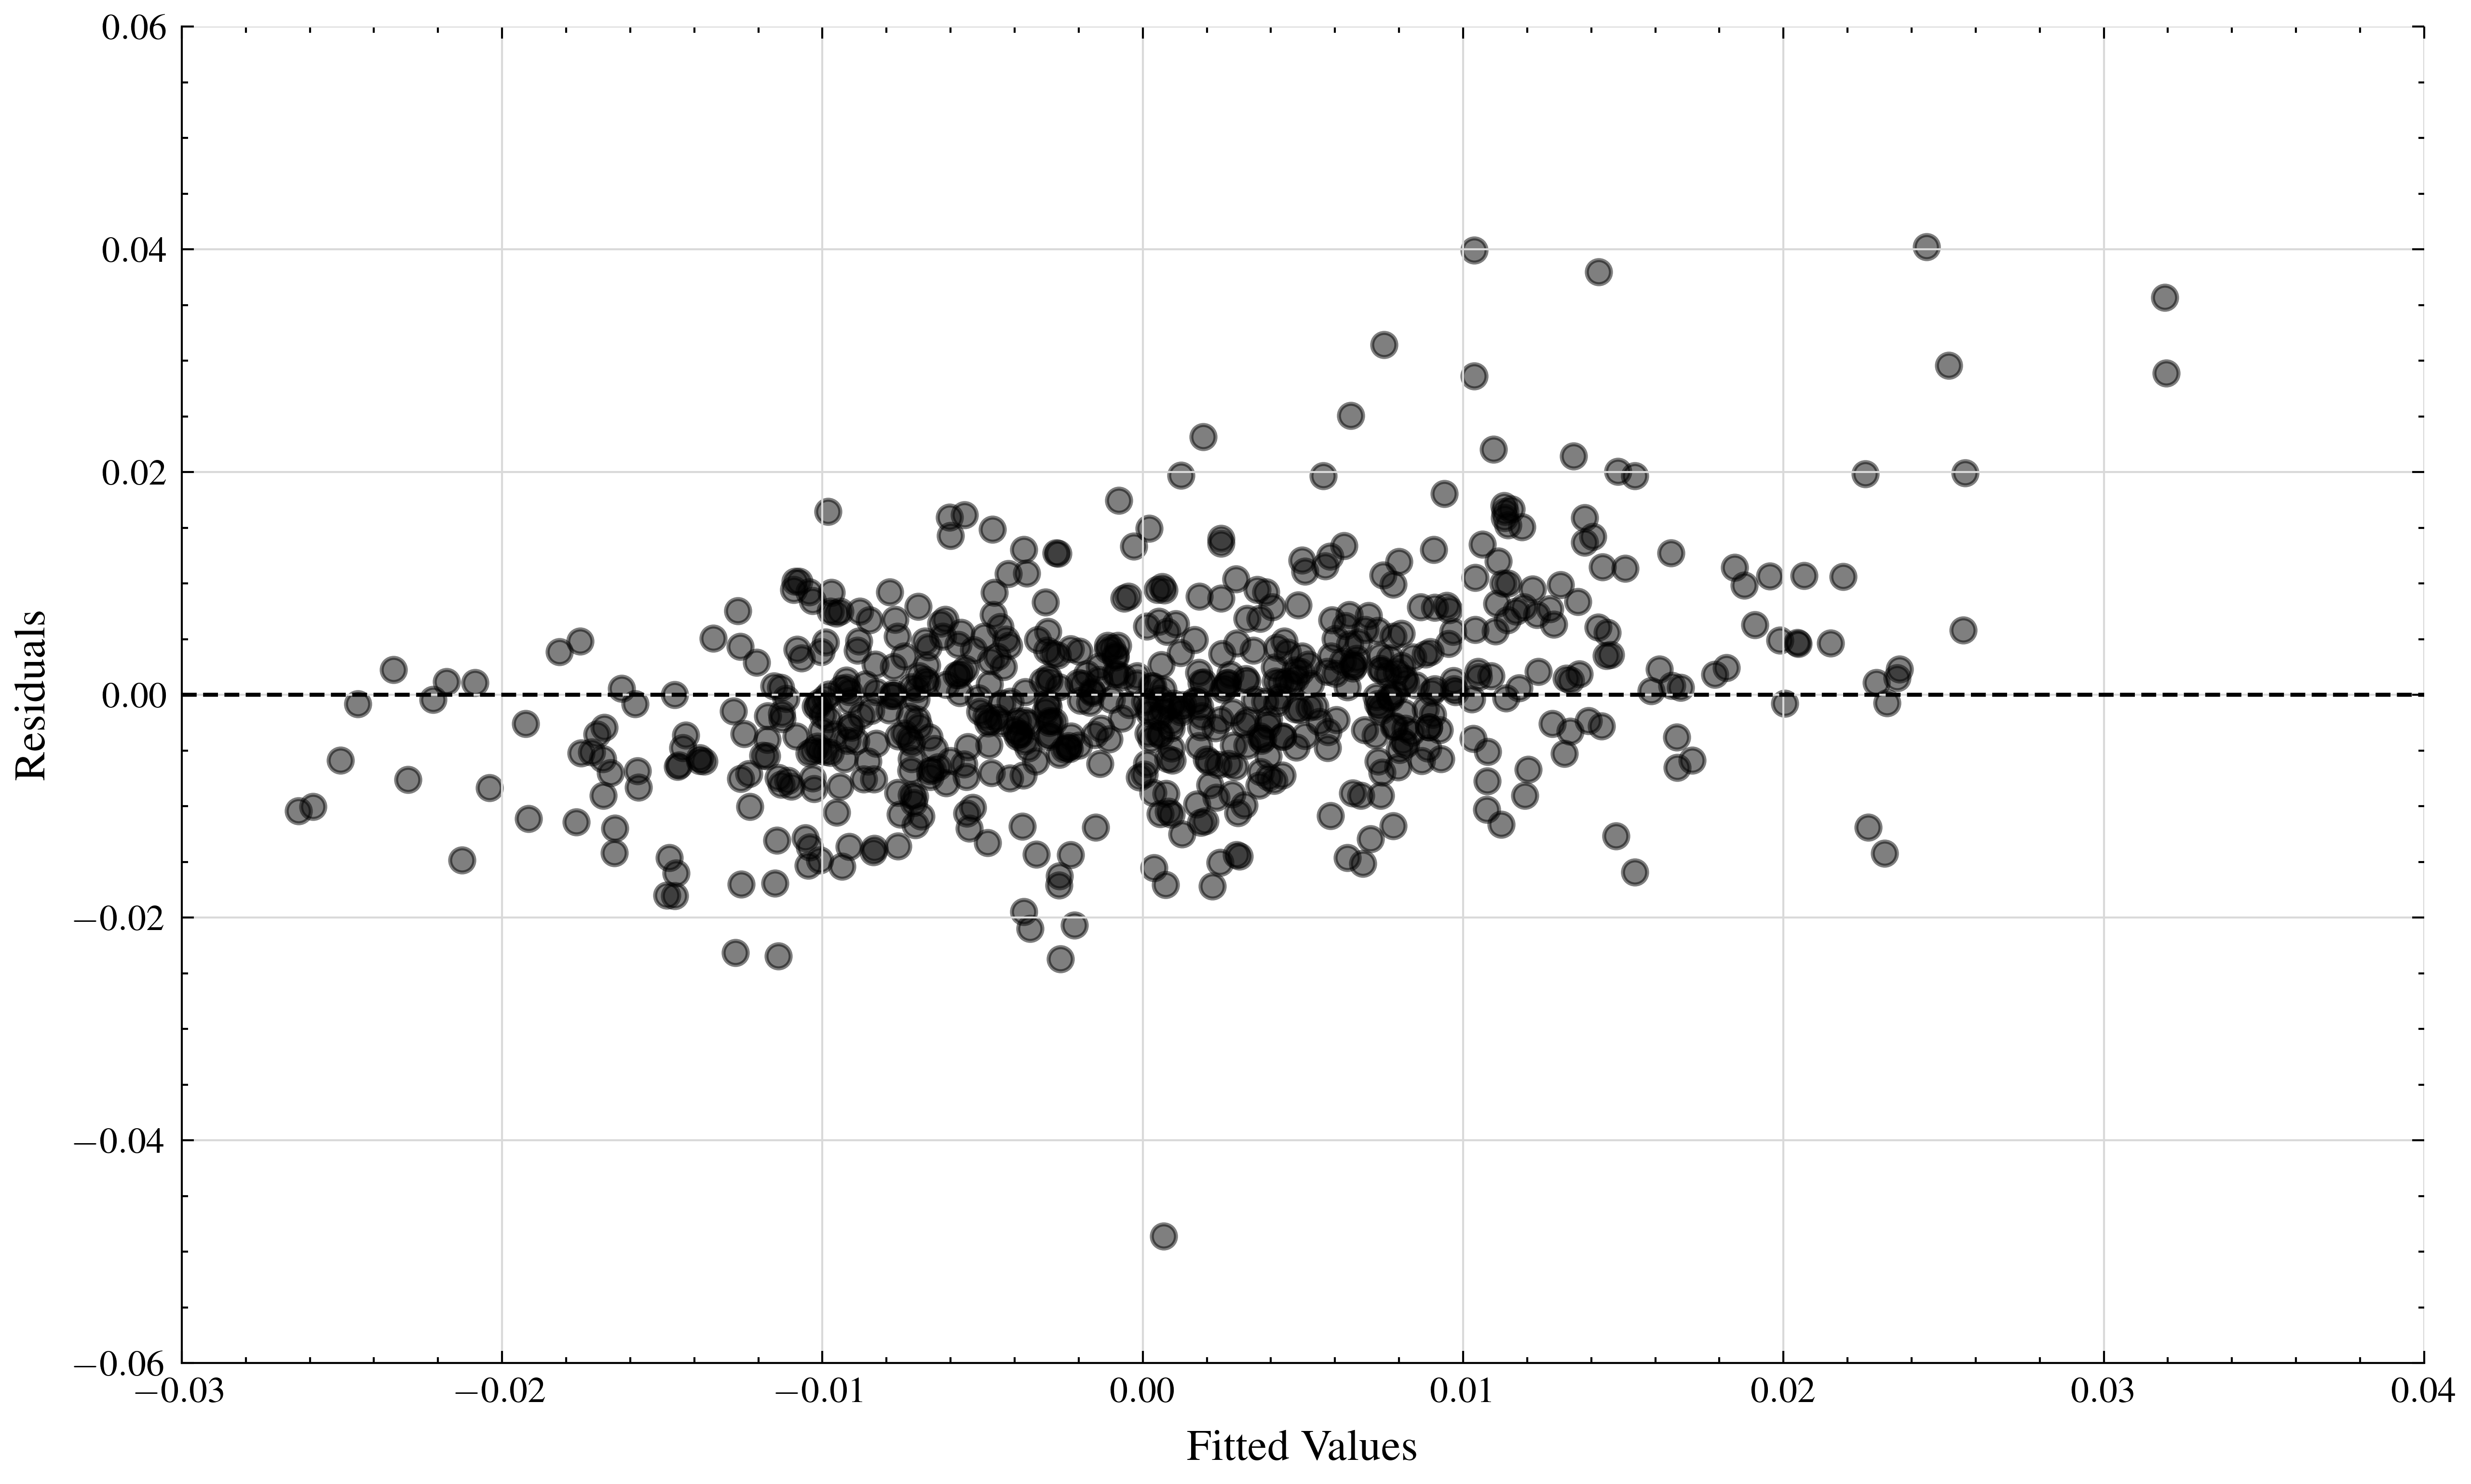

Displayed: Residuals plot for testrf1 - sample


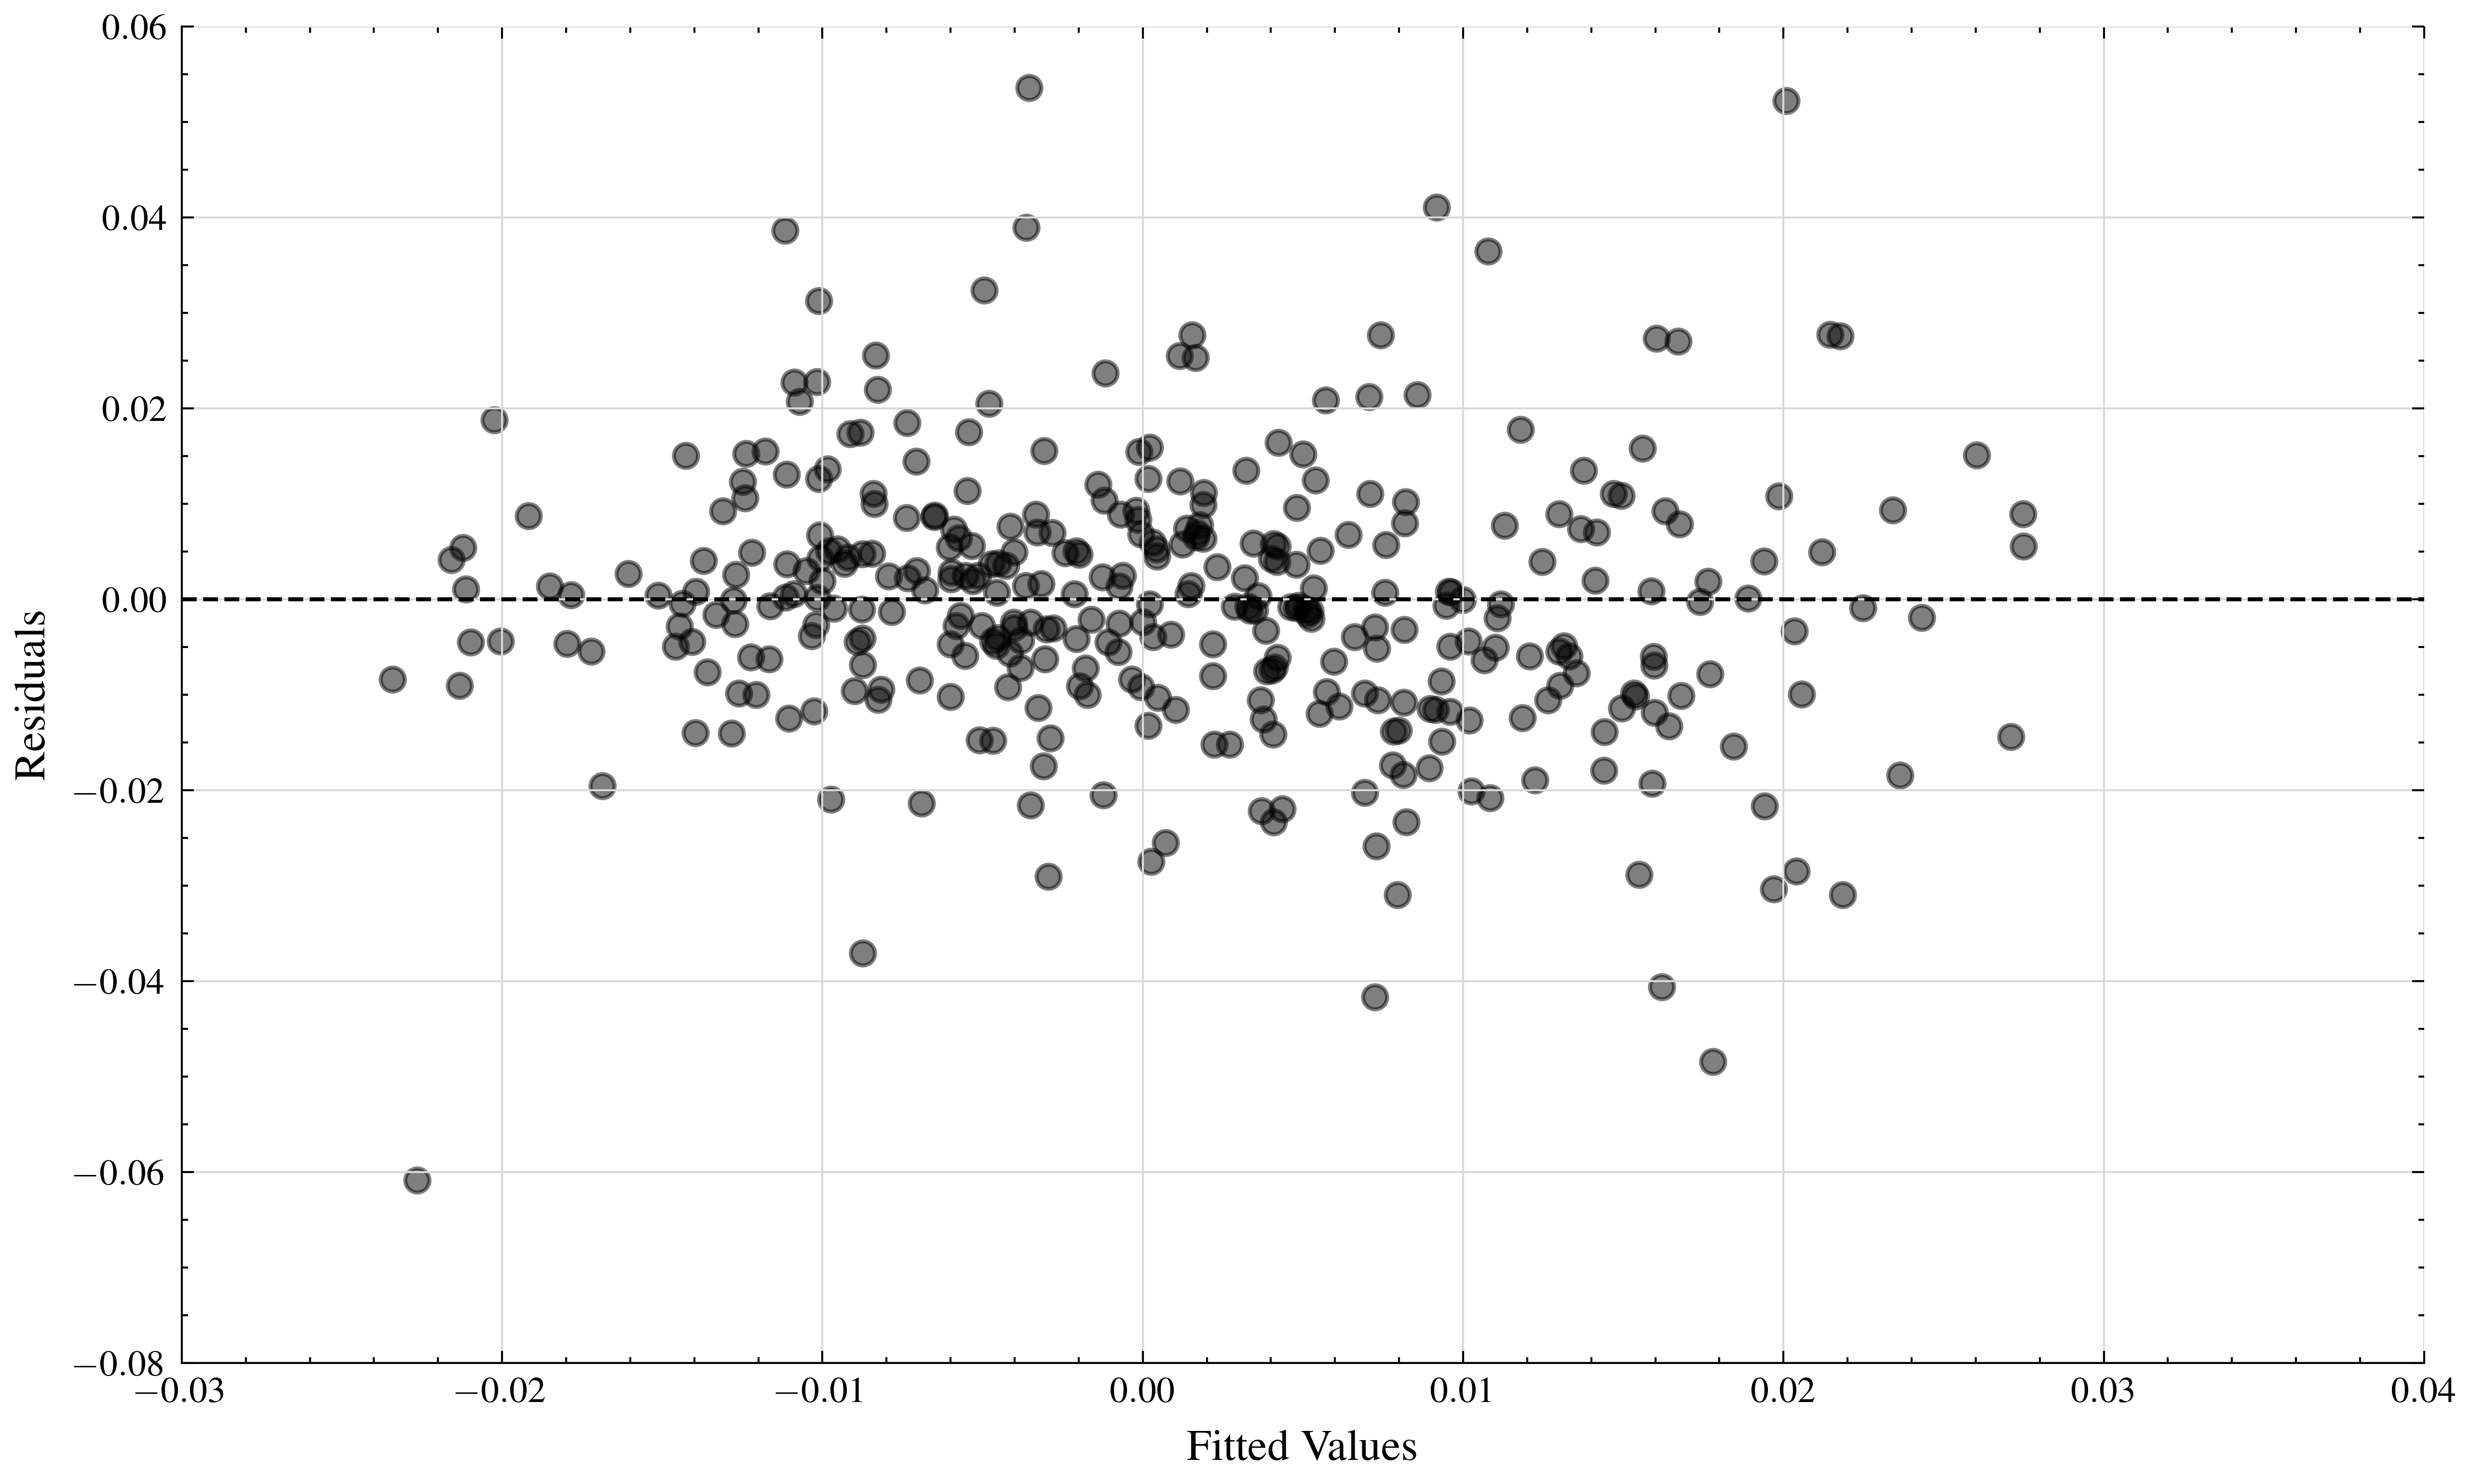

Displayed: Residuals plot for testrf1 - hold


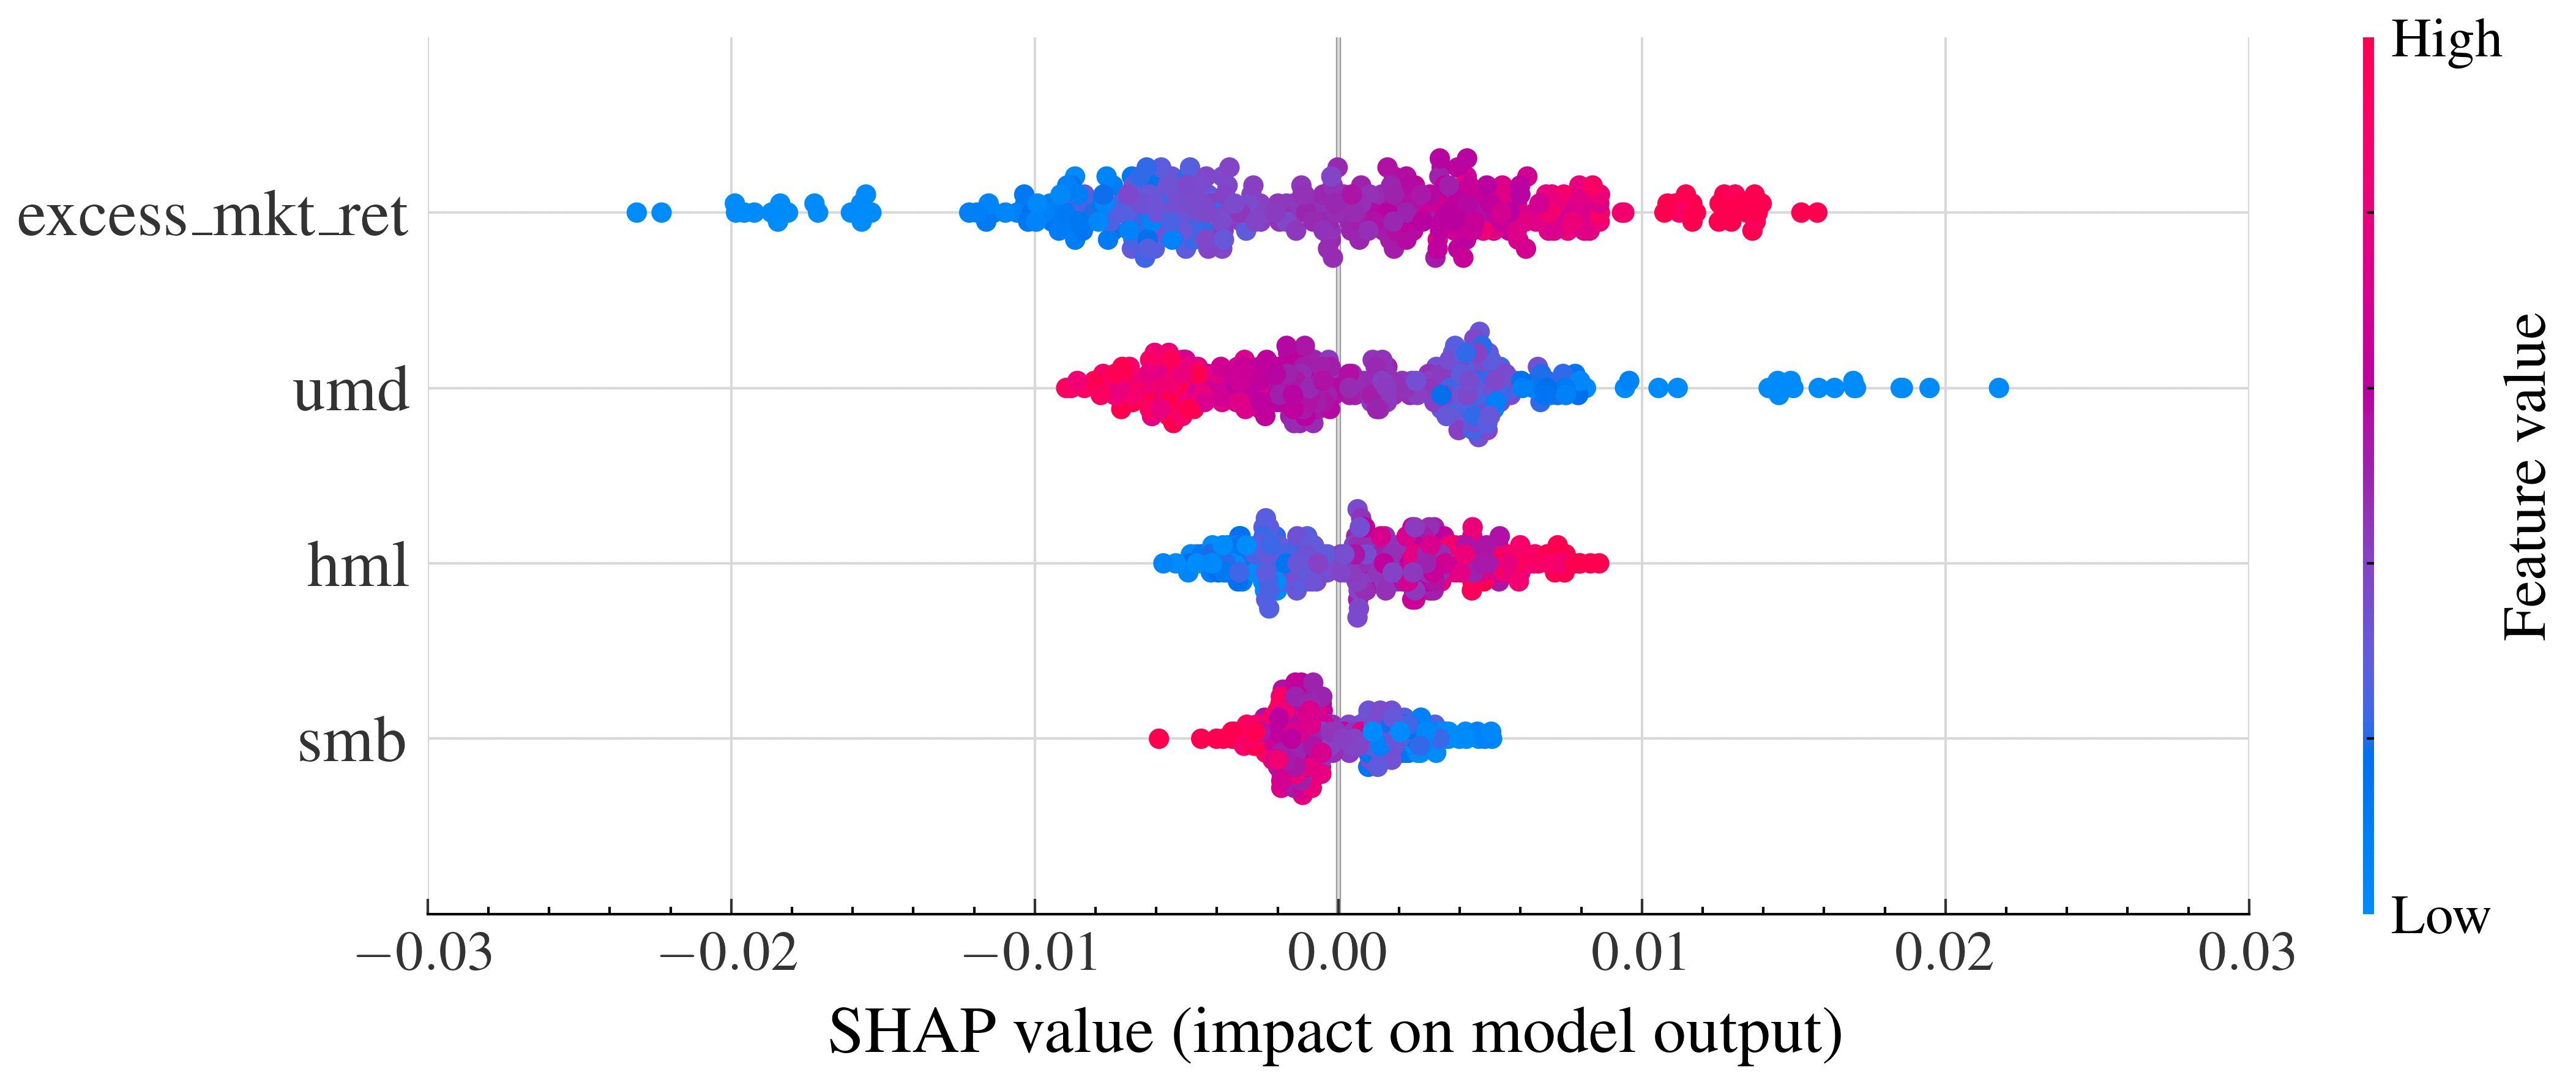

Displayed: SHAP beeswarm plot for testrf1


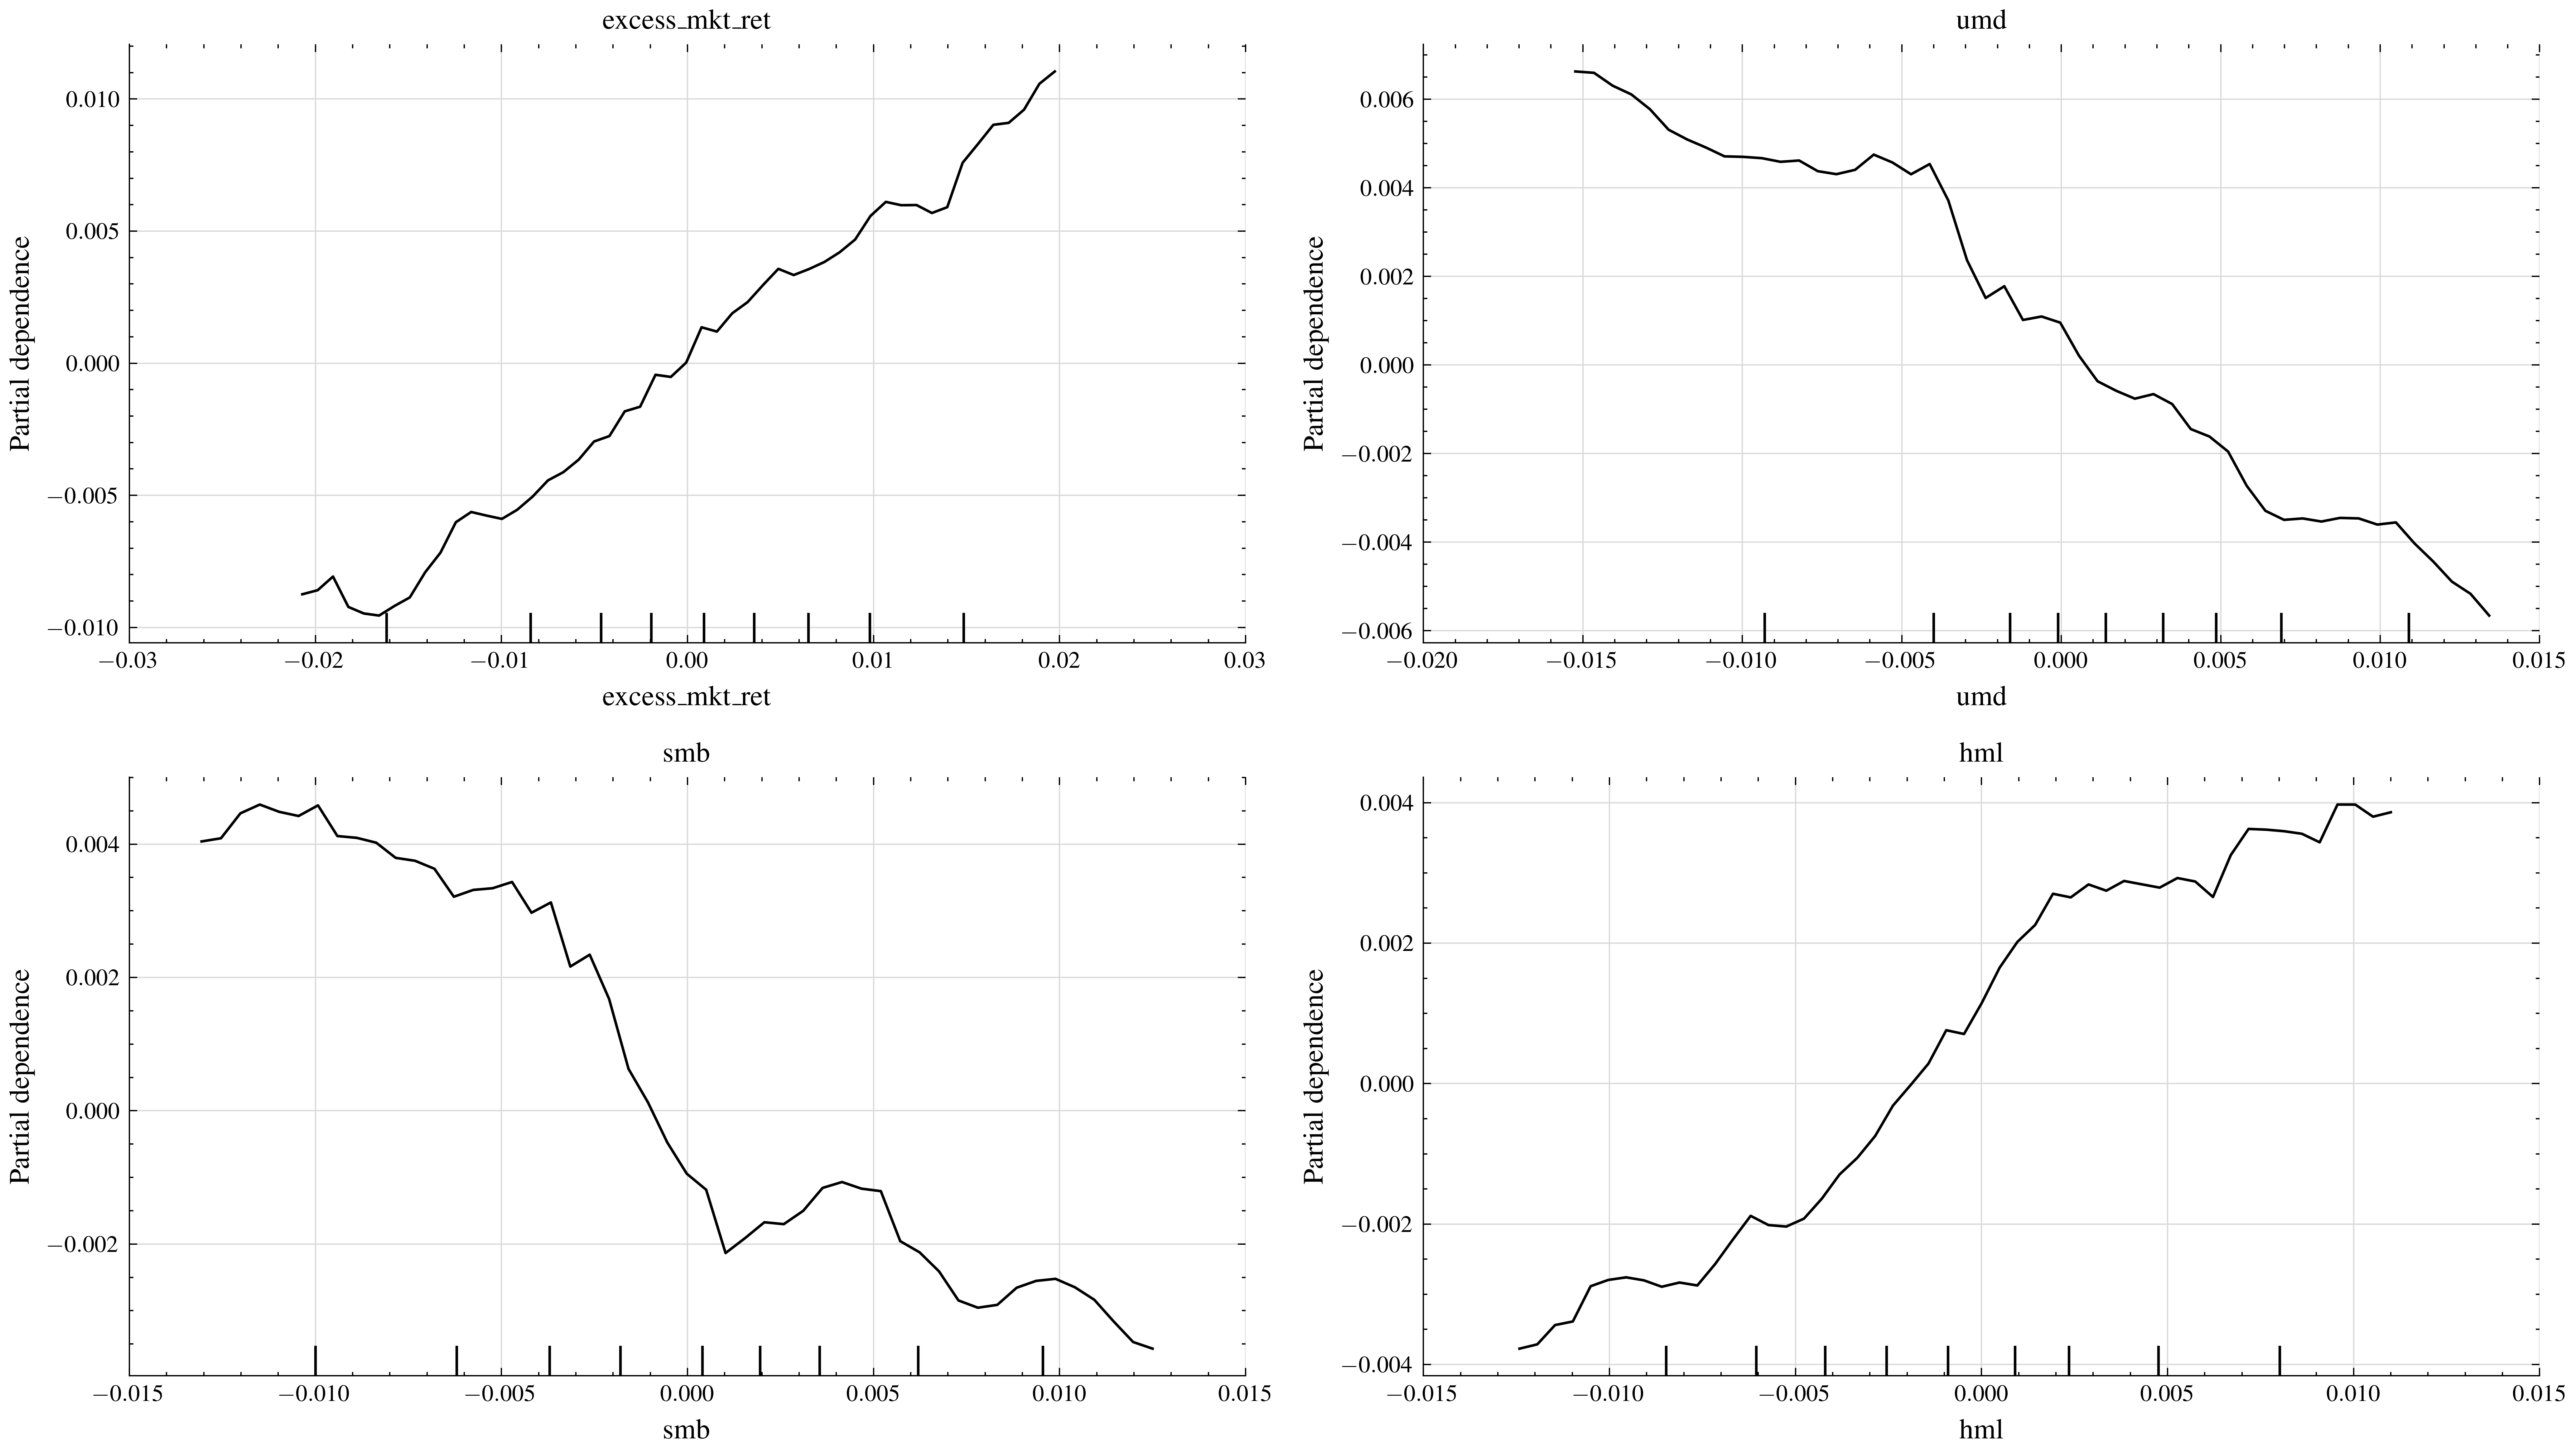

Index(['excess_mkt_ret', 'smb', 'hml', 'umd'], dtype='object')
Index(['excess_mkt_ret', 'smb', 'hml', 'umd'], dtype='object')
🏃 View run testrf1 at: http://127.0.0.1:5000/#/experiments/580106255596875282/runs/eefd0d96a8104aac8bce245746f029b0
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/580106255596875282


In [15]:
test_rf_neg = models.randomforest(
    y='excess_ret',
    features=features_c4f,
    lags=3, 
    run_name=f'testrf1',
    fama_french_ver='c4f',
    experiment_name='r2negtest'
    )
test_rf_neg.fit(df_dict['15'].iloc[:1000])

OFFICIAL RUNS

In [ ]:
for sector, df in df_dict.items():
    rf_model = models.randomforest(
    y='excess_ret',
    features=features_c4f,
    lags=3, 
    run_name=f'{sector}_rf',
    fama_french_ver='c4f',
    experiment_name='rf'
    )
    rf_model.fit(df)
  

In [ ]:
for sector, df in df_dict.items():
    rf_model = models.randomforest(
    y='excess_ret',
    features=features_c4f_enhanced,
    lags=3, 
    run_name=f'{sector}_rf_enhanced',
    fama_french_ver='c4f_enhanced',
    experiment_name='enhanced_rf'
    )
    rf_model.fit(df)
  

In [ ]:
for sector, df in df_dict.items():
    rf_model = models.randomforest(
    y='excess_ret',
    features=features_ff5,
    lags=3, 
    run_name=f'{sector}_rf',
    fama_french_ver='ff5',
    experiment_name='rf'
    )
    rf_model.fit(df)
  

In [ ]:
for sector, df in df_dict.items():
    rf_model = models.randomforest(
    y='excess_ret',
    features=features_ff5_enhanced,
    lags=3, 
    run_name=f'{sector}_rf_enhanced',
    fama_french_ver='ff5_enhanced',
    experiment_name='enhanced_rf'
    )
    rf_model.fit(df)

# Memory safety issue:
- Nested parallel : randomized search spawns instances of rf, it should be using all cores. However, if the actual RF instance inside of the grid search also does that then it would spin up crazy amounts of workers

# Clean up procedures

In [10]:
import os
target_dir = os.getcwd()

# Check the directory exists
if not os.path.isdir(target_dir):
    print(f"Directory {target_dir} does not exist.")
else:
    # Loop through files only in the 'py' directory (not subdirs)
    deleted = 0
    for filename in os.listdir(target_dir):
        full_path = os.path.join(target_dir, filename)
        if os.path.isfile(full_path) and filename.lower().endswith('.png'):
            os.remove(full_path)
            print(f"Deleted: {filename}")
            deleted += 1
    print(f"Deleted {deleted} .png files from {target_dir}")


Deleted: testrf_rf_pdp.png
Deleted: r2negtest_sample_residuals_plot.png
Deleted: rf_testrf_permutation_importance.png
Deleted: r2negtest_hold_residuals_plot.png
Deleted: testrf_hold_residuals_plot.png
Deleted: testrf_surrogate_tree_plot.png
Deleted: testrf_sample_residuals_plot.png
Deleted: testrf_shap_plot.png
Deleted 8 .png files from /Users/minhquangngo/Documents/vsc/erasmus/msc_thesis/py


# Rulefit 

/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/IPython/extensions/deduperreload/deduperreload.py:290: DeprecationWarning: ast.Ellipsis is deprecated and will be removed in Python 3.14; use ast.Constant instead
  elif not isinstance(ast_elt, (ast.Ellipsis, ast.Pass)):
/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/IPython/extensions/deduperreload/deduperreload.py:290: DeprecationWarning: ast.Ellipsis is deprecated and will be removed in Python 3.14; use ast.Constant instead
  elif not isinstance(ast_elt, (ast.Ellipsis, ast.Pass)):
/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/IPython/extensions/deduperreload/deduperreload.py:290: DeprecationWarning: ast.Ellipsis is deprecated and will be removed in Python 3.14; use ast.Constant instead
  elif not isinstance(ast_elt, (ast.Ellipsis, ast.Pass)):
/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/IPython/extensions/deduperreload/deduperreload.py:290: DeprecationWarning: ast.Ellipsis is deprecated

Experiment 472696010305606469 created


/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/imodels/util/score.py:86: UserWarning: Ignoring max_rules parameter since alpha passed explicitly
  warn("Ignoring max_rules parameter since alpha passed explicitly")
/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/imodels/util/score.py:86: UserWarning: Ignoring max_rules parameter since alpha passed explicitly
  warn("Ignoring max_rules parameter since alpha passed explicitly")
/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/imodels/util/score.py:86: UserWarning: Ignoring max_rules parameter since alpha passed explicitly
  warn("Ignoring max_rules parameter since alpha passed explicitly")
/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/imodels/util/score.py:86: UserWarning: Ignoring max_rules parameter since alpha passed explicitly
  warn("Ignoring max_rules parameter since alpha passed explicitly")
/opt/anaconda3/envs/mscthesis/lib/python3.12/site-packages/imodels/util/score.py:86: UserWarning

<Figure size 6000x3600 with 0 Axes>

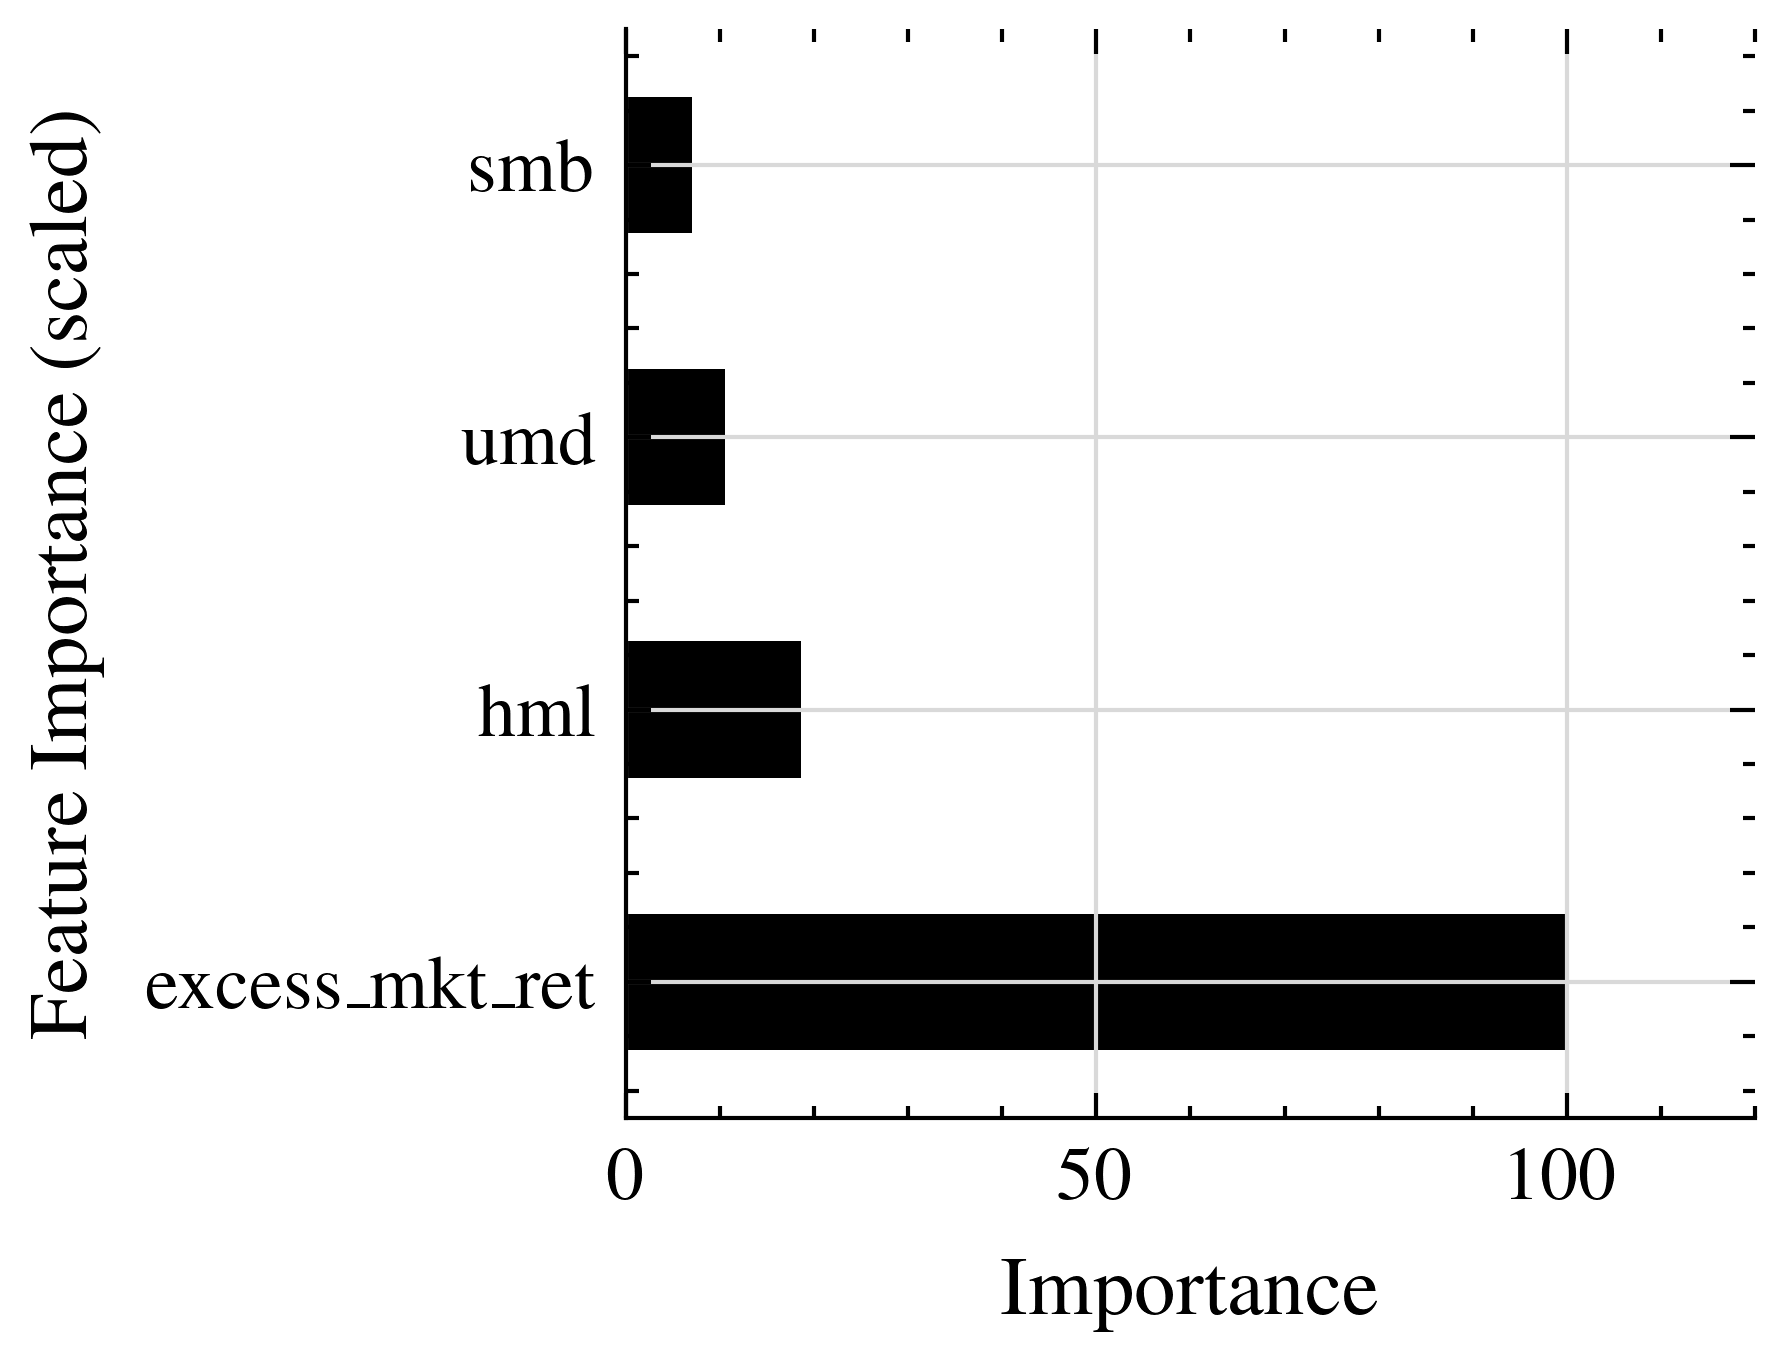

r20.7764865481377528, 0.09387599352395315
🏃 View run test rulefit at: http://127.0.0.1:5000/#/experiments/472696010305606469/runs/8d424626a2294c49a58e5876beaf9419
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/472696010305606469


In [22]:
rule_model = models.rulefit(
    y='excess_ret',
    features=features_c4f,
    lags=3, 
    run_name='test rulefit',
    fama_french_ver='c4f',
    experiment_name='testrulefit'
    )
rule_model.fit(df_dict['15'].iloc[:550])